# Introduction
Will be creating a neural network that will include 2 hidden layers to classify Fashion MNIST images.

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


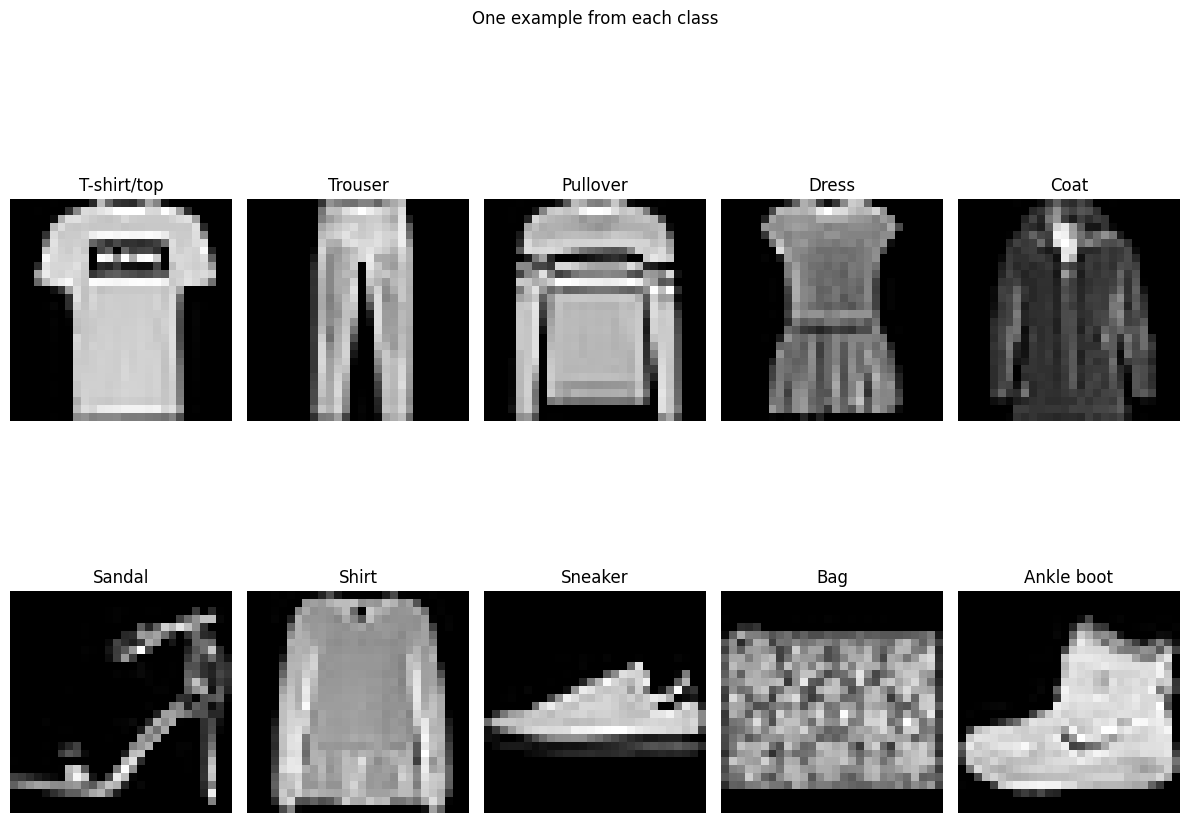

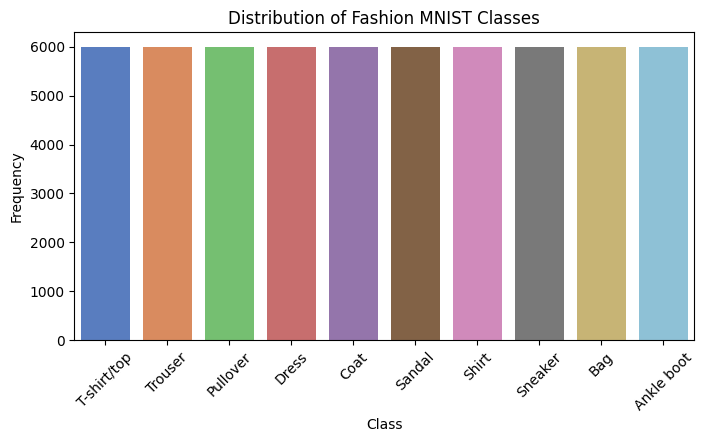

Flattened x_train shape: (60000, 784)
Flattened x_test shape: (10000, 784)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
import os
if os.path.exists("best_model.npz"):
    os.remove("best_model.npz")

# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Class names for readability
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 1. Shape info
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# 2. Visualize one image from each class
plt.figure(figsize=(12, 10))
for class_idx in range(10):
    # Find the first image of this class
    idx = np.where(y_train == class_idx)[0][0]
    plt.subplot(2, 5, class_idx + 1)
    plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
    plt.title(class_names[class_idx])
    plt.axis('off')
plt.suptitle("One example from each class")
plt.tight_layout()
plt.show()

# 3. Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette='muted')
plt.title("Distribution of Fashion MNIST Classes")
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# 4. Normalize the data from [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# 5. Flatten the images for the neural network to a 784 length vector
x_train = x_train.reshape(x_train.shape[0], -1)  # shape (60000, 784)
x_test = x_test.reshape(x_test.shape[0], -1)    # shape (10000, 784)

# Final confirmation
print(f"Flattened x_train shape: {x_train.shape}")
print(f"Flattened x_test shape: {x_test.shape}")

# Building Neural Network Architecture

In [30]:
import numpy as np

# Activation functions and derivatives
def relu(Z): return np.maximum(0, Z)
def relu_derivative(Z): return Z > 0

def leaky_relu(Z, alpha=0.01): return np.where(Z > 0, Z, alpha * Z)
def leaky_relu_derivative(Z, alpha=0.01): return np.where(Z > 0, 1, alpha)

def tanh(Z): return np.tanh(Z)
def tanh_derivative(Z): return 1 - np.tanh(Z) ** 2

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # stability
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    log_p = -np.log(y_pred[range(n_samples), y_true] + 1e-9)
    return np.sum(log_p) / n_samples

In [31]:
class FlexibleNeuralNetwork:
    def __init__(self, layer_sizes, activations, dropout_rate=0.0):
        self.num_layers = len(layer_sizes) - 1
        self.dropout_rate = dropout_rate
        self.activations = activations
        self.weights = []
        self.biases = []

        for i in range(self.num_layers):
            in_size, out_size = layer_sizes[i], layer_sizes[i + 1]
            w = np.random.randn(in_size, out_size) * np.sqrt(2. / in_size)
            b = np.zeros((1, out_size))
            self.weights.append(w)
            self.biases.append(b)

    def _activation(self, Z, func):
        if func == "relu": return relu(Z)
        if func == "leaky_relu": return leaky_relu(Z)
        if func == "tanh": return tanh(Z)
        if func == "softmax": return softmax(Z)
        return Z

    def _activation_derivative(self, Z, func):
        if func == "relu": return relu_derivative(Z)
        if func == "leaky_relu": return leaky_relu_derivative(Z)
        if func == "tanh": return tanh_derivative(Z)
        return np.ones_like(Z)
# Handles all forward propogation, and the hidden layers
    def forward(self, X, training=False):
        self.Zs = []
        self.As = [X]
        self.dropouts = []

        A = X
        for i in range(self.num_layers - 1):  # All except last
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self._activation(Z, self.activations[i])

            if training and self.dropout_rate > 0:
                dropout_mask = (np.random.rand(*A.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
                A *= dropout_mask
                self.dropouts.append(dropout_mask)
            else:
                self.dropouts.append(None)

            self.Zs.append(Z)
            self.As.append(A)

        # Final layer
        Z = np.dot(A, self.weights[-1]) + self.biases[-1]
        A = self._activation(Z, self.activations[-1])
        self.Zs.append(Z)
        self.As.append(A)

        return A  # softmax output
# Generalized backpropogation
    def backward(self, y_true, learning_rate=0.01):
        m = y_true.shape[0]
        grads_W = [None] * self.num_layers
        grads_b = [None] * self.num_layers

        # One-hot encode y_true
        y_true_encoded = np.zeros_like(self.As[-1])
        y_true_encoded[np.arange(m), y_true] = 1

        # Output layer gradient
        dZ = self.As[-1] - y_true_encoded

        for i in reversed(range(self.num_layers)):
            A_prev = self.As[i]
            grads_W[i] = np.dot(A_prev.T, dZ) / m
            grads_b[i] = np.sum(dZ, axis=0, keepdims=True) / m

            if i != 0:
                dA_prev = np.dot(dZ, self.weights[i].T)
                dZ = dA_prev * self._activation_derivative(self.Zs[i - 1], self.activations[i - 1])
                if self.dropouts[i - 1] is not None:
                    dZ *= self.dropouts[i - 1]

        # Update parameters
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * grads_W[i]
            self.biases[i] -= learning_rate * grads_b[i]

In [32]:
# Architecture: [784 → 128 → 64 → 10], with ReLU, then tanh, then softmax
model = FlexibleNeuralNetwork(
    layer_sizes=[784, 128, 64, 10], # 2 hidden layers
    activations=["relu", "tanh", "softmax"],
    dropout_rate=0.2  # Dropout only applied during training, randomly drops some neurons out to prevent overfitting
)

# Forward pass
probs = model.forward(x_train[:5], training=False)
print(probs)

[[0.01870025 0.10321468 0.17613927 0.12194893 0.21617047 0.04922663
  0.01217196 0.11502096 0.13765661 0.04975025]
 [0.00925488 0.06154633 0.24964405 0.06574774 0.28592813 0.05244838
  0.01755676 0.19434292 0.04636359 0.01716723]
 [0.03561406 0.16104284 0.17315708 0.1075774  0.1234341  0.13505913
  0.03907701 0.10862868 0.0787895  0.03762021]
 [0.02969794 0.09148151 0.21263718 0.08011563 0.19237627 0.12407544
  0.02659919 0.13711154 0.07385871 0.03204658]
 [0.0186728  0.09843576 0.23292857 0.09352407 0.23142371 0.09924593
  0.01700475 0.1233015  0.06312407 0.02233883]]


# Section to find the optimal learning rate 

In [33]:
learning_rates = [0.15, 0.1, 0.05, 0.01, 0.005, 0.001]
results = {}

for lr in learning_rates:
    print(f"\n Training with learning rate = {lr}")
    
    model = FlexibleNeuralNetwork(
        layer_sizes=[784, 128, 64, 10],
        activations=["relu", "tanh", "softmax"],
        dropout_rate=0.2
    )

    history = train(
        model,
        X_train_small, y_train_small,
        X_val, y_val,
        epochs=10,                # Short run for comparison
        batch_size=64,
        learning_rate=lr
    )

    final_acc = history["val_accuracy"][-1]
    results[lr] = final_acc
    print(f" Validation Accuracy at lr={lr}: {final_acc:.4f}")


 Training with learning rate = 0.15
Epoch 1/10 - Loss: 0.5462 - Val Accuracy: 0.7898
 Saving new best model...
Epoch 2/10 - Loss: 0.5434 - Val Accuracy: 0.7996
 Saving new best model...
Epoch 3/10 - Loss: 0.4726 - Val Accuracy: 0.8330
 Saving new best model...
Epoch 4/10 - Loss: 0.3621 - Val Accuracy: 0.8682
 Saving new best model...
Epoch 5/10 - Loss: 0.4276 - Val Accuracy: 0.8496
Epoch 6/10 - Loss: 0.4267 - Val Accuracy: 0.8452
Epoch 7/10 - Loss: 0.4303 - Val Accuracy: 0.8443
Epoch 8/10 - Loss: 0.3391 - Val Accuracy: 0.8767
 Saving new best model...
Epoch 9/10 - Loss: 0.3403 - Val Accuracy: 0.8766
Epoch 10/10 - Loss: 0.3979 - Val Accuracy: 0.8569
 Validation Accuracy at lr=0.15: 0.8569

 Training with learning rate = 0.1
Epoch 1/10 - Loss: 0.4762 - Val Accuracy: 0.8186
 Saving new best model...
Epoch 2/10 - Loss: 0.5726 - Val Accuracy: 0.8086
Epoch 3/10 - Loss: 0.5421 - Val Accuracy: 0.7993
Epoch 4/10 - Loss: 0.3648 - Val Accuracy: 0.8655
 Saving new best model...
Epoch 5/10 - Loss:

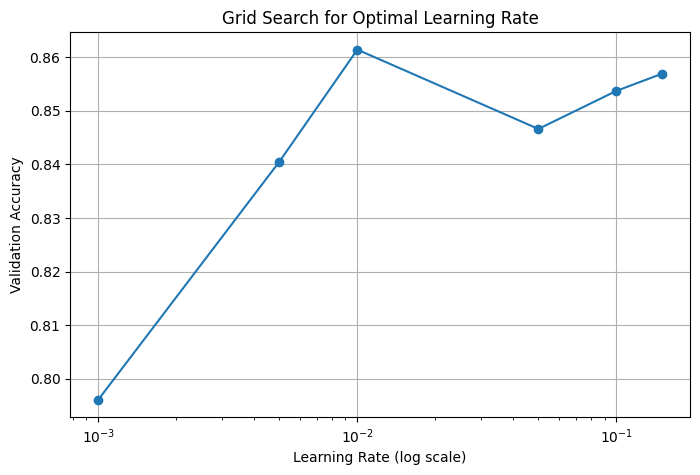

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results.keys(), results.values(), marker='o')
plt.xscale('log')
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Validation Accuracy")
plt.title("Grid Search for Optimal Learning Rate")
plt.grid(True)
plt.show()

In [35]:
best_lr = max(results, key=results.get)
print(f" Best learning rate: {best_lr} with accuracy: {results[best_lr]:.4f}")

 Best learning rate: 0.01 with accuracy: 0.8614


# Training model

In [36]:
def train(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64, learning_rate=0.1, save_path="best_model.npz"):
    history = {"loss": [], "val_accuracy": []}
    best_val_acc = 0  #  This line is essential

    for epoch in range(epochs):
        # Shuffle data
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        
        # Mini-batch training
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward + Backward
            model.forward(X_batch, training=True)
            model.backward(y_batch, learning_rate)
        
        # Epoch summary
        y_pred_val = model.forward(X_val)
        val_loss = cross_entropy_loss(y_val, y_pred_val)
        val_preds = np.argmax(y_pred_val, axis=1)
        val_acc = np.mean(val_preds == y_val)
        
        history["loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {val_loss:.4f} - Val Accuracy: {val_acc:.4f}")
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(" Saving new best model...")
            save_dict = {}
            for i, (W, b) in enumerate(zip(model.weights, model.biases)):
                save_dict[f"W{i}"] = W
                save_dict[f"b{i}"] = b
            np.savez(save_path, **save_dict)          # <- writes W0, b0, W1, b1, ...\
    return history

In [37]:
# Reserve last 10,000 for validation
X_val = x_train[-10000:]
y_val = y_train[-10000:]
X_train_small = x_train[:-10000]
y_train_small = y_train[:-10000]

In [38]:
def load_model(model, path="best_model.npz"):
    data = np.load(path)
    num_layers = len(model.weights)
    model.weights = [data[f"W{i}"] for i in range(num_layers)]
    model.biases  = [data[f"b{i}"] for i in range(num_layers)]
model = FlexibleNeuralNetwork(
    layer_sizes=[784, 128, 64, 10],
    activations=["relu", "tanh", "softmax"],
    dropout_rate=0.2
)

history = train(
    model,
    X_train_small, y_train_small,
    X_val, y_val,
    epochs=30, batch_size=64,
    learning_rate=best_lr,
    save_path="best_model.npz"   # << will be created anew
)

Epoch 1/30 - Loss: 0.6344 - Val Accuracy: 0.7838
 Saving new best model...
Epoch 2/30 - Loss: 0.5465 - Val Accuracy: 0.8086
 Saving new best model...
Epoch 3/30 - Loss: 0.4975 - Val Accuracy: 0.8199
 Saving new best model...
Epoch 4/30 - Loss: 0.4699 - Val Accuracy: 0.8312
 Saving new best model...
Epoch 5/30 - Loss: 0.4597 - Val Accuracy: 0.8341
 Saving new best model...
Epoch 6/30 - Loss: 0.4413 - Val Accuracy: 0.8424
 Saving new best model...
Epoch 7/30 - Loss: 0.4249 - Val Accuracy: 0.8475
 Saving new best model...
Epoch 8/30 - Loss: 0.4214 - Val Accuracy: 0.8483
 Saving new best model...
Epoch 9/30 - Loss: 0.4347 - Val Accuracy: 0.8432
Epoch 10/30 - Loss: 0.4086 - Val Accuracy: 0.8524
 Saving new best model...
Epoch 11/30 - Loss: 0.4112 - Val Accuracy: 0.8527
 Saving new best model...
Epoch 12/30 - Loss: 0.3953 - Val Accuracy: 0.8608
 Saving new best model...
Epoch 13/30 - Loss: 0.3834 - Val Accuracy: 0.8615
 Saving new best model...
Epoch 14/30 - Loss: 0.3800 - Val Accuracy: 0.86

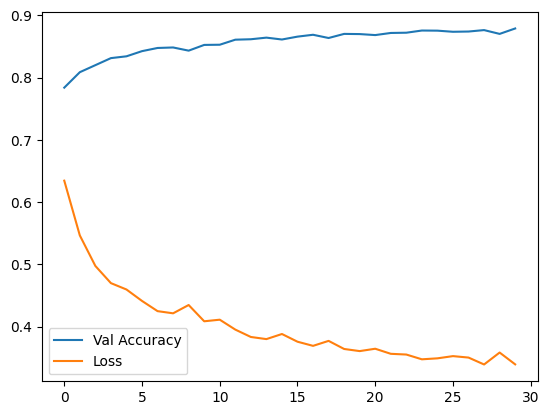

In [39]:
plt.plot(history["val_accuracy"], label="Val Accuracy")
plt.plot(history["loss"], label="Loss")
plt.legend()
plt.show()

# Evaluating the Model

Test accuracy (best checkpoint): 0.8705


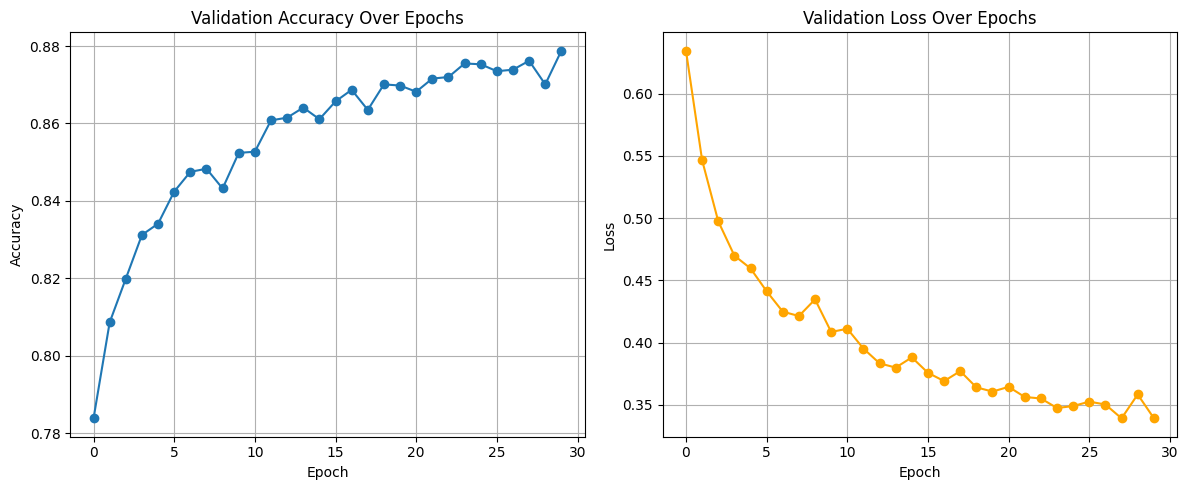

In [40]:
import matplotlib.pyplot as plt

model_loaded = FlexibleNeuralNetwork(
    layer_sizes=[784, 128, 64, 10],
    activations=["relu", "tanh", "softmax"]
)
load_model(model_loaded, "best_model.npz")   # ← pulls weights into model_loaded

test_probs = model_loaded.forward(x_test, training=False)
test_preds = np.argmax(test_probs, axis=1)
test_acc   = np.mean(test_preds == y_test)
print(f"Test accuracy (best checkpoint): {test_acc:.4f}")

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["val_accuracy"], marker='o')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history["loss"], marker='o', color='orange')
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

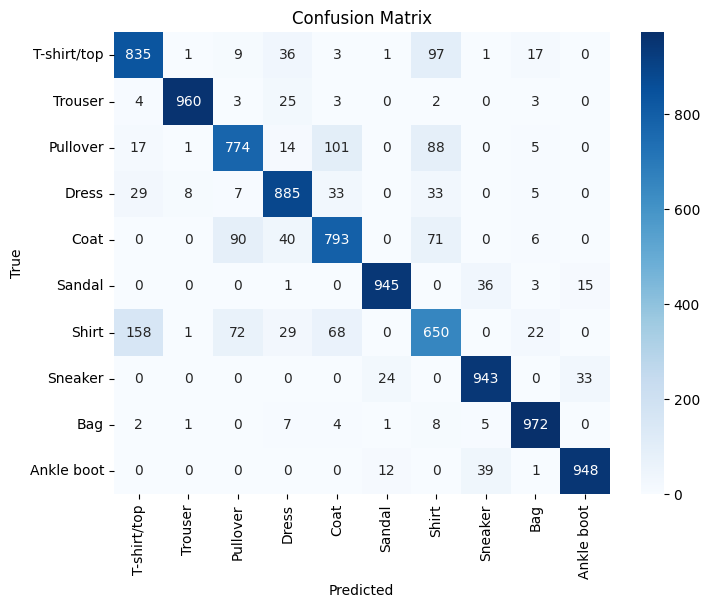

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model_loaded.forward(x_test, training=False), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Conclusion

We built a flexible neural network from scratch using NumPy to classify Fashion MNIST images.
The final architecture had two hidden layers with ReLU and tanh activations and used dropout for regularization.

- Best test accuracy: 87.05
- Observed strong performance on well-defined classes like "Sneakers", while confusion occurred between "Shirt" and "T-shirt/top"
- Parameter tuning (dropout, learning rate, layer sizes) was crucial to improve generalization.

Overall, the model met expectations and successfully learned a complex image classification task without using any deep learning library like TensorFlow or PyTorch.